In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
from sklearn.cluster import KMeans
from shapely.geometry import MultiPolygon
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import multiprocessing
import warnings
warnings.filterwarnings('ignore', message='.*unary_union.*')

In [2]:
lodes = pd.read_csv("data/LODES.csv", low_memory=False)
census = pd.read_csv("data/Decennial_Census.csv")
shapes = gpd.read_file("data/tract_shapefiles/il_t_2020_bound.shp")

In [3]:
lodes.drop("Unnamed: 0", axis=1, inplace=True)
census.drop("Unnamed: 0", axis=1, inplace=True)
shapes = shapes[['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'GEOID20', 'geometry']]
shapes = shapes.to_crs(epsg=3435)
census["block_code"] = census["geo_id"].apply(lambda x: x[-11:])

In [4]:
census["block_code"] = census["geo_id"].apply(lambda x: x[-11:])
IL_blocks = [int(i) for i in census.block_code.values]

In [5]:
lodes["home_block_code"] = lodes["home_block_code"].apply(lambda x: str(x)[:11])
lodes["workplace_block_code"] = lodes["workplace_block_code"].apply(lambda x: str(x)[:11])

In [29]:
pastDistricts = gpd.read_file("data/2023Districts/tl_2023_17_cd118.shp")

In [ ]:
import multiprocessing
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

class ILRedistricting:
    def __init__(self, census_df, shapes_df, lodes_df, past_districts_df, n_districts=17):

        # Ensure 'block_code' and 'GEOID20' are strings for merging - sometimes an issue! 
        self.census = census_df.copy()
        self.shapes = shapes_df.copy()
        self.lodes = lodes_df.copy()
        self.past_districts = past_districts_df.copy()
        self.n_districts = n_districts

        self.census['block_code'] = self.census['block_code'].astype(str)
        self.shapes['GEOID20'] = self.shapes['GEOID20'].astype(str)
        self.lodes['home_block_code'] = self.lodes['home_block_code'].astype(str)
        self.lodes['workplace_block_code'] = self.lodes['workplace_block_code'].astype(str)

        self.data = self.census.merge(self.shapes[['GEOID20', 'geometry']], left_on='block_code', right_on='GEOID20', how='left')
        self.data = self.data.drop(columns=['GEOID20'])

        # Ensure 'geometry' column is of type Geometry (in case it's not)
        if not isinstance(self.data.geometry, gpd.GeoSeries):
            self.data = gpd.GeoDataFrame(self.data, geometry='geometry')

        # Set CRS if not set 
        if self.data.crs is None:
            self.data.set_crs(epsg=3435, inplace=True)  # Assuming EPSG 3435; adjust if needed when input format is different

        self.block_to_idx = dict(zip(self.data['block_code'], range(len(self.data))))
        self.commute_flows = self._precompute_commute_flows()
        self.G = self._create_block_graph()
        
        # Initialize with past districts approximated onto tracts
        self.initial_districts = self.create_initial_districts()
            
    def _precompute_commute_flows(self):
        return dict(zip(
            zip(self.lodes['home_block_code'], self.lodes['workplace_block_code']),
            self.lodes['total_jobs']
        ))
    
    def _create_block_graph(self):
        G = nx.Graph()
        
        # Add nodes
        node_attrs = {row['block_code']: {
            'population': row['total_houses'],
            'occupied': row['occupied_houses'],
            'vacant': row['vacant_houses'],
            'hispanic': row['hispanic_latino'],
            'white': row['white'],
            'black': row['black'],
            'asian': row['asian'],
            'native': row['american_indian_alaska_native'],
            'pacific': row['pacific_islander'],
            'other_race': row['other_race'],
            'multiracial': row['multiracial'],
            'institutional_pop': row['total_institutionalized'],
            'prison_pop': row['prison_pop'],
            'juvenile_pop': row['juvenile_detention_pop'],
            'nursing_pop': row['nursing_home_pop'],
            'college_pop': row['college_dorm_pop'],
            'military_pop': row['military_housing_pop'],
            'other_group_pop': row['other_group_quarters_pop'],
            'geometry': row['geometry']
        } for idx, row in self.data.iterrows()}
        
        G.add_nodes_from([(k, v) for k, v in node_attrs.items()])
        
        # Build spatial index
        self.data = self.data.reset_index(drop=True)
        self.data['geometry'] = self.data['geometry'].buffer(0)
        sindex = self.data.sindex
        
        # Parallel edge creation
        n_cores = max(1, multiprocessing.cpu_count() - 1)
        with ProcessPoolExecutor(max_workers=n_cores) as executor:
            chunk_size = len(self.data) // n_cores
            futures = []
            
            for start in range(0, len(self.data), chunk_size):
                end = min(start + chunk_size, len(self.data))
                futures.append(executor.submit(self._process_geometry_chunk, start, end))
            
            edges = []
            for future in futures:
                edges.extend(future.result())
        
        G.add_edges_from(edges)
        
        for (home, work), jobs in self.commute_flows.items():
            if G.has_edge(home, work):
                G[home][work]['commute_weight'] = jobs
            else:
                G.add_edge(home, work, type='commute', commute_weight=jobs)
        
        return G
    
    def _process_geometry_chunk(self, start, end):
        edges = []
        data_chunk = self.data.iloc[start:end]
        sindex = self.data.sindex
        for idx1, row1 in data_chunk.iterrows():
            geom1 = row1['geometry']
            if geom1 is None or geom1.is_empty:
                continue
            possible_matches_index = list(sindex.intersection(geom1.bounds))
            possible_matches = self.data.iloc[possible_matches_index]
            for idx2, row2 in possible_matches.iterrows():
                if idx1 >= idx2:
                    continue
                geom2 = row2['geometry']
                if geom2 is None or geom2.is_empty:
                    continue
                if geom1.touches(geom2):
                    edges.append((
                        row1['block_code'],
                        row2['block_code'],
                        {'type': 'adjacent'}
                    ))
        return edges
    
    def create_initial_districts(self):
        """Initialize districts based on existing congressional districts"""
        # Ensure CRS match - common bug on import!
        if self.past_districts.crs != self.data.crs:
            self.past_districts = self.past_districts.to_crs(self.data.crs)
        
        past_districts_sindex = self.past_districts.sindex
        
        districts = np.zeros(len(self.data), dtype=int)
        
        # For each census block/tract
        for idx, block in self.data.iterrows():
            block_geom = block.geometry
            if block_geom is None or block_geom.is_empty:
                continue
                
            possible_matches_idx = list(past_districts_sindex.intersection(block_geom.bounds))
            possible_matches = self.past_districts.iloc[possible_matches_idx]
            
            centroid = block_geom.centroid
            for dist_idx, district in possible_matches.iterrows():
                try:
                    cd_num = district['CD118FP']
                    if not cd_num.isdigit():
                        continue
                    if district.geometry.contains(centroid):
                        district_num = int(cd_num) - 1
                        districts[idx] = district_num
                        break
                except (ValueError, AttributeError):
                    continue
                        
            # If no district contains the centroid, use the one with largest overlap
            if districts[idx] == 0:
                max_overlap = 0
                best_district = 0
                for dist_idx, district in possible_matches.iterrows():
                    try:
                        cd_num = district['CD118FP']
                        # Skip non-numeric or invalid district numbers
                        if not cd_num.isdigit():
                            continue
                        overlap = block_geom.intersection(district.geometry).area
                        if overlap > max_overlap:
                            max_overlap = overlap
                            best_district = int(cd_num) - 1
                    except (ValueError, AttributeError):
                        continue
                districts[idx] = best_district
        
        return districts
    
    def evaluate_districts(self, districts):
        """Used for optimization scoring with improved weights and penalties"""
        evaluation = self.evaluate_plan_quality(districts)
        
        # Calculate more nuanced scores than simple absolutes
        scores = {
            # Heavy penalty for population deviation, exponential to strongly discourage large deviations
            'population_deviation': -100.0 * np.exp(evaluation['population']['max_deviation'] * 10),
            
            # Reward for minority districts, with diminishing returns above current level
            'minority_districts': 10.0 * evaluation['minority']['minority_districts'],
            
            # Compactness score with higher weight
            'compactness': 5.0 * evaluation['compactness']['mean_score'],
            
            # Institutional splits penalty
            'institutional_splits': -5.0 * self._calculate_institutional_splits(districts),
            
            # Commute preservation reward
            'commute_preservation': 2.0 * evaluation['commuting']['preserved_percentage']
        }
        
        # Additional penalties for severe violations
        if evaluation['population']['max_deviation'] > 0.10:  # More than 10% deviation
            scores['population_deviation'] *= 2  # Double the penalty
            
        if evaluation['minority']['minority_districts'] < 13:  # Don't allow fewer minority districts
            scores['minority_districts'] = -1000.0  # Heavy penalty
        
        total_score = sum(scores.values())
        
        return total_score, scores
    
    def _calculate_institutional_splits(self, districts):
        splits = 0
        institutional_cols = ['prison_pop', 'juvenile_detention_pop', 
                              'nursing_home_pop', 'college_dorm_pop',
                              'military_housing_pop']
        
        block_to_idx = self.block_to_idx
        
        district_mapping = dict(zip(self.data['block_code'], districts))
        
        for col in institutional_cols:
            inst_blocks = self.data[self.data[col] > 0]
            for idx, row in inst_blocks.iterrows():
                block_code = row['block_code']
                block_district = district_mapping[block_code]
                
                for neighbor in self.G.neighbors(block_code):
                    if neighbor in district_mapping and district_mapping[neighbor] != block_district:
                        splits += row[col]
                        break
        return splits
    
    def _calculate_commute_splits(self, districts):
        splits = 0
        district_mapping = dict(zip(self.data['block_code'], districts))
        
        for (home, work), jobs in self.commute_flows.items():
            if (home in district_mapping and work in district_mapping and 
                district_mapping[home] != district_mapping[work]):
                splits += jobs
        return splits
    
    def optimize(self, n_iterations=1000):
        """Modified optimization with stricter acceptance criteria"""
        np.random.seed(42)
        current_districts = self.initial_districts.copy()
        current_score, current_metrics = self.evaluate_districts(current_districts)
        
        best_districts = current_districts.copy()
        best_score = current_score
        best_metrics = current_metrics
        
        initial_temperature = 0.1 
        temperature = initial_temperature
        cooling_rate = 1.0 - (1.0 / n_iterations)
        no_improvement_count = 0
        restart_threshold = 50 
        max_restarts = 5 
        restart_count = 0
        
        print("Starting optimization...")
        print(f"Initial score: {current_score:.4f}")
        
        for iteration in range(n_iterations):
            new_districts = self._propose_change(current_districts)
            new_score, new_metrics = self.evaluate_districts(new_districts)
            
            # Only accept changes that meet minimum criteria
            population_got_worse = (
                self.evaluate_plan_quality(new_districts)['population']['max_deviation'] >
                self.evaluate_plan_quality(current_districts)['population']['max_deviation'] * 1.1
            )
            
            minority_got_worse = (
                self.evaluate_plan_quality(new_districts)['minority']['minority_districts'] <
                self.evaluate_plan_quality(current_districts)['minority']['minority_districts']
            )
            
            delta = new_score - current_score
            if (delta > 0 and not population_got_worse and not minority_got_worse) or \
            (np.random.random() < np.exp(delta / temperature) and 
                not population_got_worse and not minority_got_worse):
                current_districts = new_districts
                current_score = new_score
                current_metrics = new_metrics
            
            if current_score > best_score:
                best_districts = current_districts.copy()
                best_score = current_score
                best_metrics = current_metrics
                no_improvement_count = 0
                print(f"New best score: {best_score:.4f} at iteration {iteration}")
            else:
                no_improvement_count += 1
            
            if no_improvement_count > restart_threshold and restart_count < max_restarts:
                print(f"Restarting at iteration {iteration}")
                temperature = initial_temperature
                current_districts = self.initial_districts.copy()
                current_score, current_metrics = self.evaluate_districts(current_districts)
                no_improvement_count = 0
                restart_count += 1
            
            temperature *= cooling_rate
            
            if iteration % 50 == 0:
                print(f"Iteration {iteration}, Score: {current_score:.4f}, Best: {best_score:.4f}")
        
        print("Optimization complete!")
        return best_districts, best_score, best_metrics
    
    def _find_boundary_blocks(self, districts):
        """Simplified boundary block finding using basic spatial operations"""
        blocks_gdf = self.data.copy()
        blocks_gdf['dist_assign'] = districts
        boundary_blocks = []
        
        for idx, block in blocks_gdf.iterrows():
            block_geom = block.geometry
            potential_neighbors = blocks_gdf[
                blocks_gdf.geometry.touches(block_geom) &
                (blocks_gdf.index != idx)
            ]
            
            if not potential_neighbors.empty:
                block_district = districts[idx]
                neighbor_districts = potential_neighbors['dist_assign'].values
                if any(d != block_district for d in neighbor_districts):
                    boundary_blocks.append(block['block_code'])
        
        return boundary_blocks
    
    def _propose_change(self, districts):
        """Simplified proposal method without spatial joins"""
        new_districts = districts.copy()
        block_to_idx = self.block_to_idx
        
        boundary_blocks = self._find_boundary_blocks(districts)
        if not boundary_blocks:
            return new_districts
        
        blocks_gdf = self.data.copy()
        blocks_gdf['dist_assign'] = districts
        
        for _ in range(min(10, len(boundary_blocks))):
            block = np.random.choice(boundary_blocks)
            current_district = districts[block_to_idx[block]]
            
            # Find neighbors using basic spatial operations
            block_geom = blocks_gdf.loc[blocks_gdf['block_code'] == block, 'geometry'].iloc[0]
            neighbors = blocks_gdf[
                blocks_gdf.geometry.touches(block_geom) &
                (blocks_gdf['dist_assign'] != current_district)
            ]
            
            if neighbors.empty:
                continue
            
            # Find valid target districts
            valid_targets = set()
            for neighbor_district in neighbors['dist_assign'].unique():
                temp_districts = districts.copy()
                temp_districts[block_to_idx[block]] = neighbor_district
                
                # Check contiguity for both districts
                if (self._check_contiguity(temp_districts, [current_district]) and 
                    self._check_contiguity(temp_districts, [neighbor_district])):
                    valid_targets.add(neighbor_district)
            
            if valid_targets:
                new_district = np.random.choice(list(valid_targets))
                new_districts[block_to_idx[block]] = new_district
                if all(self._check_contiguity(new_districts, [d]) for d in {current_district, new_district}):
                    return new_districts
        
        return districts
        
    def _check_contiguity(self, districts, district_ids):
        """Simplified contiguity check using basic spatial operations"""
        for district_id in district_ids:
            district_blocks = self.data[districts == district_id].copy()
            if len(district_blocks) <= 1:
                continue
            
            visited = set([district_blocks.index[0]])
            to_visit = set([district_blocks.index[0]])
            
            # While we have blocks to visit
            while to_visit:
                current = to_visit.pop()
                current_geom = district_blocks.loc[current, 'geometry']
                
                # Find touching blocks within the same district
                neighbors = district_blocks[
                    district_blocks.geometry.touches(current_geom) &
                    ~district_blocks.index.isin(visited)
                ]
                
                # Add new neighbors to visit
                for idx in neighbors.index:
                    if idx not in visited:
                        visited.add(idx)
                        to_visit.add(idx)
            
            # If we haven't visited all blocks, the district is not contiguous - lwk could make this faster
            if len(visited) != len(district_blocks):
                return False
        
        return True
    def _calculate_compactness(self, districts):
        """Calculates compactness using Polsby-Popper measure"""
        compactness_scores = []
        self.data['district'] = districts
        for i in range(self.n_districts):
            district_shapes = self.data[self.data['district'] == i]
            if len(district_shapes) > 0:
                union = district_shapes.geometry.unary_union
                area = union.area
                perimeter = union.length
                if perimeter > 0:
                    score = 4 * np.pi * area / (perimeter * perimeter)
                    compactness_scores.append(score)
        return np.mean(compactness_scores)
    
    def evaluate_plan_quality(self, districts):
        """Evaluates the quality of a districting plan across multiple metrics"""
        evaluation = {}
        
        # Population Equality
        populations = np.bincount(districts, weights=self.data['total_houses'].values, 
                                  minlength=self.n_districts)
        target_pop = populations.sum() / self.n_districts
        max_deviation = np.max(np.abs(populations - target_pop)) / target_pop
        
        evaluation['population'] = {
            'max_deviation': max_deviation,
            'max_deviation_pct': max_deviation * 100,
            'district_populations': populations.tolist(),
            'within_legal_limit': max_deviation <= 0.05
        }
        
        # Racial/Minority Representation
        minority_cols = ['hispanic_latino', 'black', 'asian', 'american_indian_alaska_native',
                         'pacific_islander', 'other_race', 'multiracial']
        minority_pop = np.zeros(len(districts))
        for col in minority_cols:
            if col in self.data.columns:
                minority_pop += self.data[col].values
            else:
                self.data[col] = 0  # If column is missing, assume zero
        
        minority_by_district = np.bincount(districts, weights=minority_pop, 
                                           minlength=self.n_districts)
        minority_percentages = np.divide(minority_by_district, populations, 
                                         out=np.zeros_like(minority_by_district), where=populations!=0)
        
        evaluation['minority'] = {
            'minority_districts': int(np.sum(minority_percentages > 0.5)),
            'district_percentages': minority_percentages.tolist(),
            'overall_representation': np.sum(minority_pop) / np.sum(populations)
        }
        
        # Compactness
        evaluation['compactness'] = {
            'mean_score': self._calculate_compactness(districts),
            'district_scores': [self._calculate_district_compactness(districts, i) 
                                for i in range(self.n_districts)]
        }
        
        # Commuting Communities/LODES
        total_commuters = sum(self.commute_flows.values())
        split_commuters = self._calculate_commute_splits(districts)
        
        preserved_percentage = 100 - (split_commuters / total_commuters) * 100 if total_commuters > 0 else 0
        
        evaluation['commuting'] = {
            'split_percentage': 100 - preserved_percentage,
            'preserved_percentage': preserved_percentage,
            'total_splits': split_commuters
        }
        
        return evaluation

    def _calculate_district_compactness(self, districts, district_id):
        self.data['district'] = districts
        district_shapes = self.data[self.data['district'] == district_id]
        if len(district_shapes) > 0:
            union = district_shapes.geometry.unary_union
            area = union.area
            perimeter = union.length
            if perimeter > 0:
                return 4 * np.pi * area / (perimeter * perimeter)
        return 0
    
    def plot_districts(self, initial_districts=None, optimized_districts=None):
        """Plots initial and optimized districts with population distributions"""
        fig = plt.figure(figsize=(20, 15))
        
        # District maps
        ax1 = plt.subplot2grid((2, 2), (0, 0))
        ax2 = plt.subplot2grid((2, 2), (0, 1))
        
        # Population distributions
        ax3 = plt.subplot2grid((2, 2), (1, 0))
        ax4 = plt.subplot2grid((2, 2), (1, 1))
        
        if initial_districts is not None:
            self.data['initial_districts'] = initial_districts
            self.data.plot(column='initial_districts', cmap='tab20', ax=ax1, legend=True)
            ax1.set_title('Initial Districts')
            ax1.axis('off')
            
            initial_pops = [self.data[self.data['initial_districts'] == i]['total_houses'].sum() 
                            for i in range(self.n_districts)]
            ax3.bar(range(self.n_districts), initial_pops)
            ax3.axhline(y=np.mean(initial_pops), color='r', linestyle='--', label='Target')
            ax3.set_title('Initial Population Distribution')
            ax3.set_xlabel('District')
            ax3.set_ylabel('Population')
            ax3.legend()
        
        if optimized_districts is not None:
            self.data['optimized_districts'] = optimized_districts
            self.data.plot(column='optimized_districts', cmap='tab20', ax=ax2, legend=True)
            ax2.set_title('Optimized Districts')
            ax2.axis('off')
            
            optimized_pops = [self.data[self.data['optimized_districts'] == i]['total_houses'].sum() 
                              for i in range(self.n_districts)]
            ax4.bar(range(self.n_districts), optimized_pops)
            ax4.axhline(y=np.mean(optimized_pops), color='r', linestyle='--', label='Target')
            ax4.set_title('Optimized Population Distribution')
            ax4.set_xlabel('District')
            ax4.set_ylabel('Population')
            ax4.legend()
        
        plt.tight_layout()
        plt.show()
    
    def print_evaluation_summary(self, districts, evaluation=None):
        """Prints a summary of the redistricting plan evaluation"""
        if evaluation is None:
            evaluation = self.evaluate_plan_quality(districts)
        
        print("\nRedistricting Plan Evaluation Summary:")
        print("-" * 50)
        
        print(f"\nPopulation Deviation:")
        print(f"Maximum deviation: {evaluation['population']['max_deviation_pct']:.2f}%")
        print(f"Legal compliance: {'Yes' if evaluation['population']['within_legal_limit'] else 'No'}")
        
        print(f"\nMinority Representation:")
        print(f"Minority-majority districts: {evaluation['minority']['minority_districts']}")
        print(f"Overall minority representation: {evaluation['minority']['overall_representation']*100:.1f}%")
        
        print(f"\nCompactness (Polsby-Popper):")
        print(f"Mean score: {evaluation['compactness']['mean_score']:.3f}")
        
        print(f"\nCommuting Communities:")
        print(f"Preserved connections: {evaluation['commuting']['preserved_percentage']:.1f}%")
        print(f"Split connections: {evaluation['commuting']['split_percentage']:.1f}%")

In [95]:
redistricter = ILRedistricting(
    census_df=census,
    shapes_df=shapes,
    lodes_df=lodes,
    past_districts_df=pastDistricts,
    n_districts=17
)

In [96]:
initial_districts = redistricter.create_initial_districts()

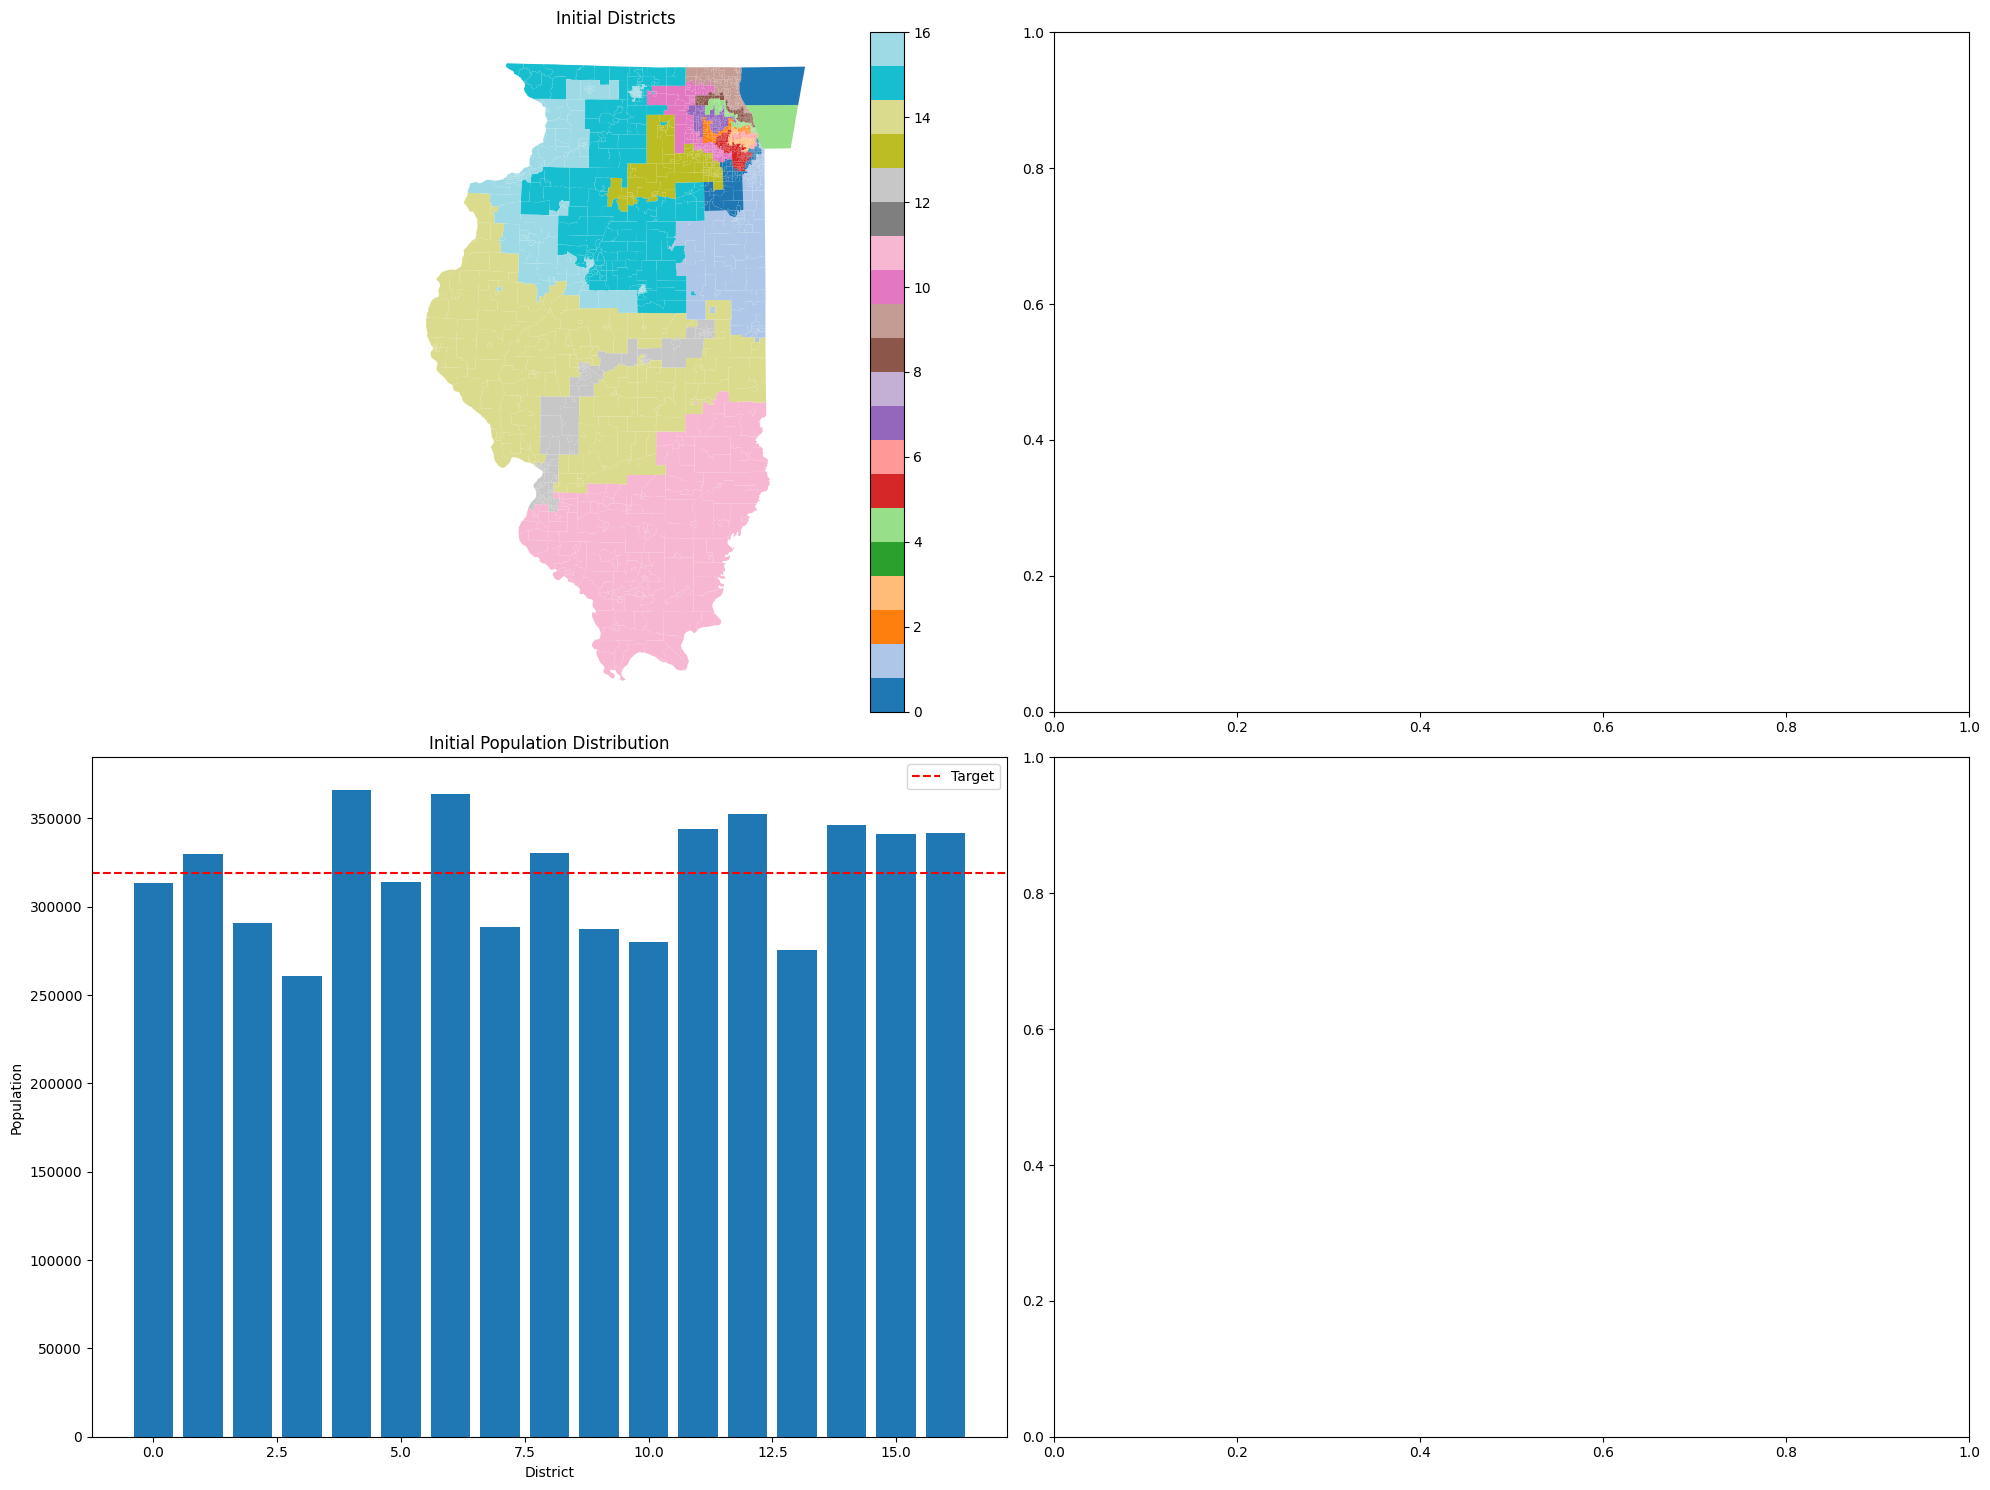

In [97]:
redistricter.plot_districts(initial_districts)

In [98]:
initial_evaluation = redistricter.evaluate_plan_quality(initial_districts)

In [99]:
best_districts, best_score, best_metrics = redistricter.optimize(n_iterations = 5000)

Starting optimization...
Initial score: -1189738.1092
Iteration 0, Score: -1189738.1092, Best: -1189738.1092
New best score: -1189714.7400 at iteration 1
New best score: -1189685.9889 at iteration 8
New best score: -1189607.1540 at iteration 14
New best score: -1189534.5849 at iteration 15
New best score: -1189534.5822 at iteration 17
New best score: -1189503.5748 at iteration 20
New best score: -1189465.4976 at iteration 21
New best score: -1189465.4952 at iteration 22
New best score: -1189453.4087 at iteration 23
New best score: -1189422.5068 at iteration 32
New best score: -1189329.3309 at iteration 34
Iteration 50, Score: -1189329.3761, Best: -1189329.3309
New best score: -1189279.5533 at iteration 74
Iteration 100, Score: -1189279.5726, Best: -1189279.5533
Restarting at iteration 125
Iteration 150, Score: -1189493.5092, Best: -1189279.5533
New best score: -1189279.4185 at iteration 173
Iteration 200, Score: -1189279.4615, Best: -1189279.4185
Restarting at iteration 224
Iteration 2

In [103]:
final_evaluation = redistricter.evaluate_plan_quality(best_districts)

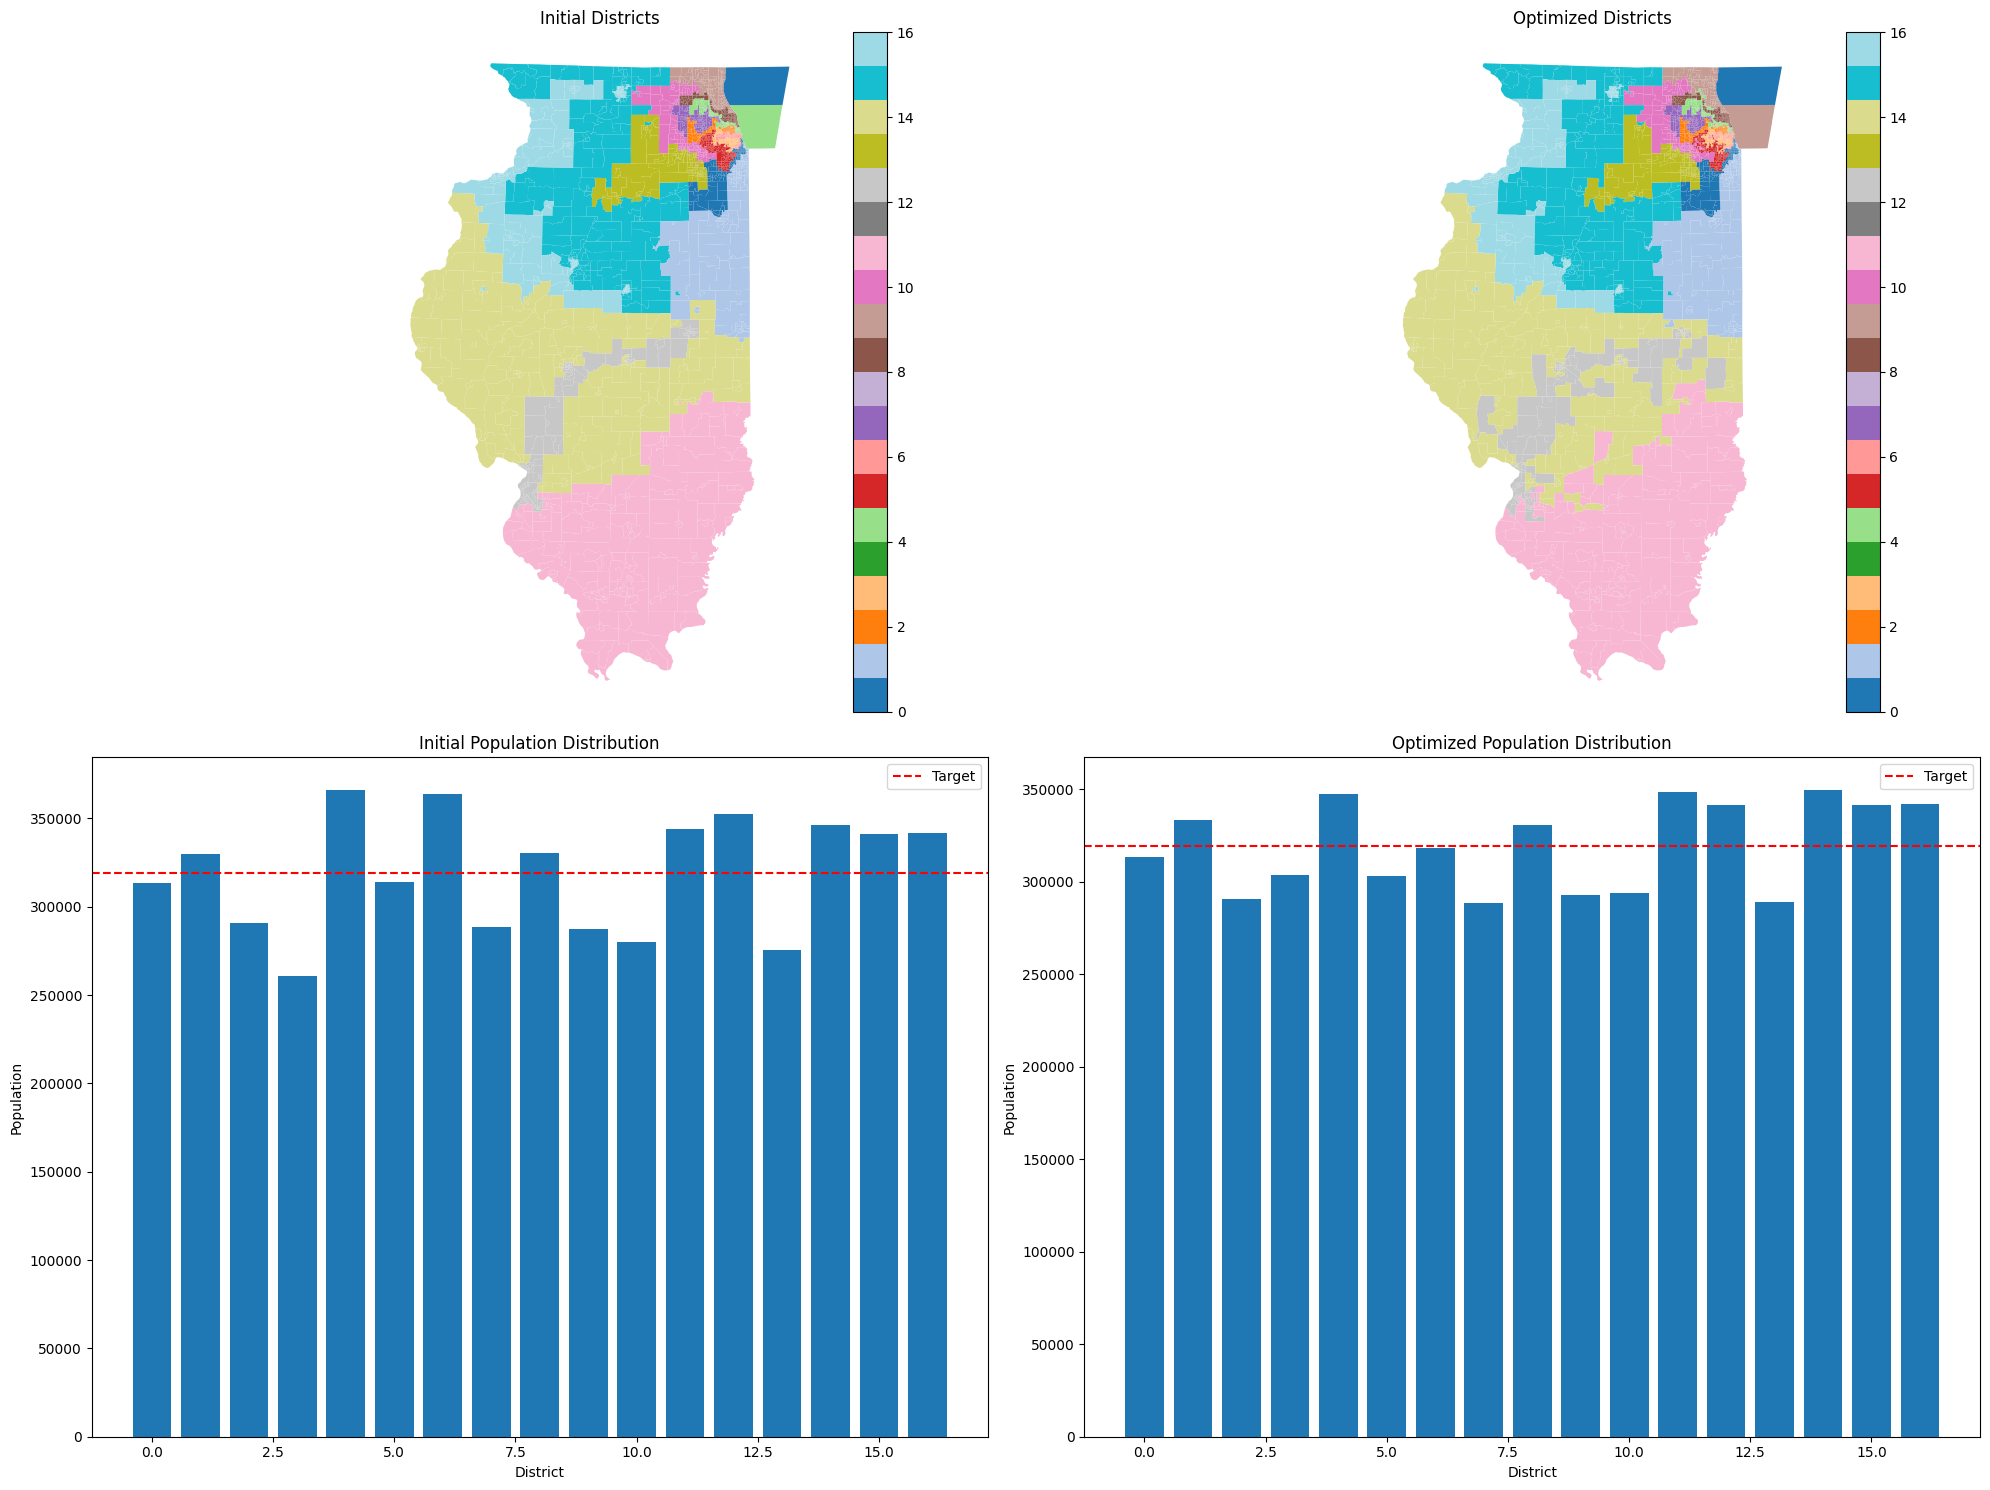

In [104]:
redistricter.plot_districts(initial_districts, best_districts)

In [105]:
print("initial:")
redistricter.print_evaluation_summary(initial_districts, initial_evaluation)
print("final")
redistricter.print_evaluation_summary(best_districts, final_evaluation)

initial:

Redistricting Plan Evaluation Summary:
--------------------------------------------------

Population Deviation:
Maximum deviation: 18.27%
Legal compliance: No

Minority Representation:
Minority-majority districts: 14
Overall minority representation: 103.1%

Compactness (Polsby-Popper):
Mean score: 0.133

Commuting Communities:
Preserved connections: 17.0%
Split connections: 83.0%
final

Redistricting Plan Evaluation Summary:
--------------------------------------------------

Population Deviation:
Maximum deviation: 9.69%
Legal compliance: No

Minority Representation:
Minority-majority districts: 14
Overall minority representation: 103.1%

Compactness (Polsby-Popper):
Mean score: 0.094

Commuting Communities:
Preserved connections: 16.5%
Split connections: 83.5%
